## **Data Loading**

In [9]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re

# Load your data
df = pd.read_csv("/kaggle/input/datasetproject/combined_dataset.csv")

In [10]:
df.head()

,Problem_Text,Equation,Answer
0,Bryan took a look at his books as well . If Br...,x=56*9,504.0
1,Bryan also looked over his books . How many bo...,x=56*9,504.0
2,Bryan also looked through his books . How many...,x=56*9,504.0
3,Bryan also looked through his novels . How man...,x=56*9,504.0
4,Bryan took a look at his comics as well . If B...,x=56*9,504.0


## **Data Splitting**

In [11]:
# Split into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

## **Dataset class**

In [13]:
class MWPDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        question = str(self.df.iloc[idx]["Problem_Text"])
        equation = str(self.df.iloc[idx]["Equation"])

        inputs = self.tokenizer(
            question,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        labels = self.tokenizer(
            equation,
            max_length=128,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": labels["input_ids"].squeeze()
        }


## **Initialize tokenizer and model**

In [14]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Create datasets and dataloaders
train_dataset = MWPDataset(train_df, tokenizer)
val_dataset = MWPDataset(val_df, tokenizer)
test_dataset = MWPDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)

optimizer = AdamW(model.parameters(), lr=3e-5)


## **Training loop with test evaluation**

In [15]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import precision_score, recall_score, f1_score
import nltk
nltk.download('punkt', quiet=True)

def evaluate_model_with_bleu(data_loader, name="Validation"):
    model.eval()
    loss = 0
    seq_correct = 0
    total_sequences = 0
    
    # Token-level metrics
    token_correct = 0
    total_tokens = 0
    
    # For BLEU score
    all_references = []
    all_candidates = []
    
    # For classification metrics
    all_token_predictions = []
    all_token_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss += outputs.loss.item()

            preds = model.generate(input_ids, max_length=128)
            pred_texts = [tokenizer.decode(p, skip_special_tokens=True) for p in preds]
            true_texts = [tokenizer.decode(lbl, skip_special_tokens=True) for lbl in labels]

            for pt, tt in zip(pred_texts, true_texts):
                pt_norm = normalize_equation(pt)
                tt_norm = normalize_equation(tt)
                
                # 1. Character level
                ref_chars = list(tt_norm)
                cand_chars = list(pt_norm)
                
                # 2. Token level 
    
                ref_tokens = re.findall(r'[a-zA-Z]+|\d+\.?\d*|[+\-*/=()^]', tt_norm)
                cand_tokens = re.findall(r'[a-zA-Z]+|\d+\.?\d*|[+\-*/=()^]', pt_norm)
                
                # Store for BLEU calculation
                all_references.append([ref_tokens])  
                all_candidates.append(cand_tokens)
                
                # SEQUENCE-LEVEL 
                if pt_norm == tt_norm:
                    seq_correct += 1
                total_sequences += 1
                
                # TOKEN-LEVEL (character by character)
                min_len = min(len(pt_norm), len(tt_norm))
                
                if min_len > 0:
                    for i in range(min_len):
                        token_matches = 1 if pt_norm[i] == tt_norm[i] else 0
                        
                        if pt_norm[i] == tt_norm[i]:
                            token_correct += 1
                        total_tokens += 1
                        
                        all_token_predictions.append(token_matches)
                        all_token_labels.append(1)

    avg_loss = loss / len(data_loader)
    
    # Calculate BLEU scores
    bleu_scores = []
    smoothing = SmoothingFunction().method1
    
    for ref, cand in zip(all_references, all_candidates):
        try:
            # Calculate BLEU-4 score
            score = sentence_bleu(ref, cand, 
                                 weights=(0.25, 0.25, 0.25, 0.25),
                                 smoothing_function=smoothing)
            bleu_scores.append(score)
        except:
            bleu_scores.append(0.0)
    
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0
    
    # Sequence-level accuracy
    seq_accuracy = seq_correct / total_sequences if total_sequences > 0 else 0.0
    
    # Token-level accuracy
    token_accuracy = token_correct / total_tokens if total_tokens > 0 else 0.0
    
    # Token-level precision, recall, f1
    if len(all_token_labels) > 0:
        token_precision = precision_score(all_token_labels, all_token_predictions, zero_division=1)
        token_recall = recall_score(all_token_labels, all_token_predictions, zero_division=1)
        token_f1 = f1_score(all_token_labels, all_token_predictions, zero_division=1)
    else:
        token_precision = token_recall = token_f1 = 0.0
    
    return (avg_loss, seq_accuracy, token_accuracy, 
            token_precision, token_recall, token_f1, avg_bleu)

In [16]:
EPOCHS = 10
train_losses = []
val_losses = []
val_seq_accuracies = []
test_seq_accuracies = []
val_token_accuracies = []
test_token_accuracies = []
val_bleu_scores = []
test_bleu_scores = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f}")

    # Evaluate on validation set
    (avg_val_loss, val_seq_acc, val_token_acc, 
     val_token_prec, val_token_rec, val_token_f1, val_bleu) = evaluate_model_with_bleu(val_loader, "Validation")
    
    val_losses.append(avg_val_loss)
    val_seq_accuracies.append(val_seq_acc)
    val_token_accuracies.append(val_token_acc)
    val_bleu_scores.append(val_bleu)

    # Evaluate on test set
    (avg_test_loss, test_seq_acc, test_token_acc,
     test_token_prec, test_token_rec, test_token_f1, test_bleu) = evaluate_model_with_bleu(test_loader, "Test")
    
    test_seq_accuracies.append(test_seq_acc)
    test_token_accuracies.append(test_token_acc)
    test_bleu_scores.append(test_bleu)

    print(f"\nValidation Results:")
    print(f"  Loss:              {avg_val_loss:.4f}")
    print(f"  Seq Accuracy:      {val_seq_acc:.4f}")
    print(f"  Token Accuracy:    {val_token_acc:.4f}")
    print(f"  BLEU-4 Score:      {val_bleu:.4f}")
    print(f"  Token Precision:   {val_token_prec:.4f}")
    print(f"  Token Recall:      {val_token_rec:.4f}")
    print(f"  Token F1:          {val_token_f1:.4f}")
    
    print(f"\nTest Results:")
    print(f"  Loss:              {avg_test_loss:.4f}")
    print(f"  Seq Accuracy:      {test_seq_acc:.4f}")
    print(f"  Token Accuracy:    {test_token_acc:.4f}")
    print(f"  BLEU-4 Score:      {test_bleu:.4f}")
    print(f"  Token Precision:   {test_token_prec:.4f}")
    print(f"  Token Recall:      {test_token_rec:.4f}")
    print(f"  Token F1:          {test_token_f1:.4f}")
    print("-" * 80)

Epoch 1/10 | Train Loss: 0.4686

Validation Results:
  Loss:              0.0991
  Seq Accuracy:      0.0222
  Token Accuracy:    0.3961
  BLEU-4 Score:      0.1854
  Token Precision:   1.0000
  Token Recall:      0.3961
  Token F1:          0.5675

Test Results:
  Loss:              0.0994
  Seq Accuracy:      0.0387
  Token Accuracy:    0.4065
  BLEU-4 Score:      0.1928
  Token Precision:   1.0000
  Token Recall:      0.4065
  Token F1:          0.5780
--------------------------------------------------------------------------------
Epoch 2/10 | Train Loss: 0.1091

Validation Results:
  Loss:              0.0742
  Seq Accuracy:      0.0889
  Token Accuracy:    0.4982
  BLEU-4 Score:      0.2718
  Token Precision:   1.0000
  Token Recall:      0.4982
  Token F1:          0.6651

Test Results:
  Loss:              0.0741
  Seq Accuracy:      0.0803
  Token Accuracy:    0.4946
  BLEU-4 Score:      0.2609
  Token Precision:   1.0000
  Token Recall:      0.4946
  Token F1:          0.6618

## **Plot training and validation loss**

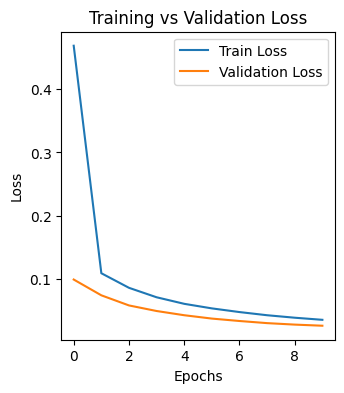

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

## **Sequence accuracy**

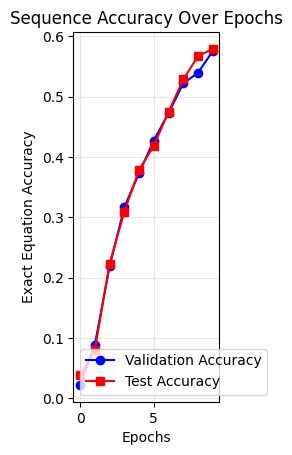

In [21]:
plt.subplot(1, 3, 2)
plt.plot(val_seq_accuracies, label="Validation Accuracy", marker='o', color='blue')
plt.plot(test_seq_accuracies, label="Test Accuracy", marker='s', color='red')
plt.xlabel("Epochs")
plt.ylabel("Exact Equation Accuracy")
plt.title("Sequence Accuracy Over Epochs")
plt.legend()
plt.grid(True, alpha=0.3)

## **BLEU Score**

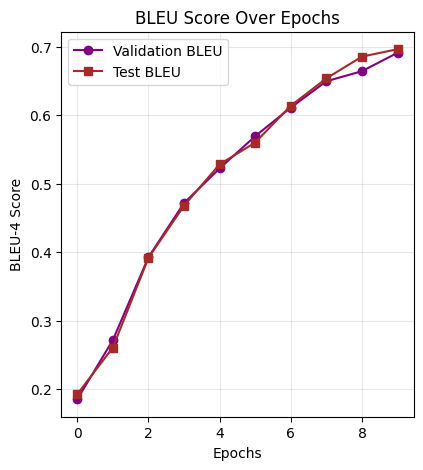

In [22]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(val_bleu_scores, label="Validation BLEU", marker='o', color='purple')
plt.plot(test_bleu_scores, label="Test BLEU", marker='s', color='brown')
plt.xlabel("Epochs")
plt.ylabel("BLEU-4 Score")
plt.title("BLEU Score Over Epochs")
plt.legend()
plt.grid(True, alpha=0.3)

In [24]:
def predict_equation(question):
    model.eval()
    inputs = tokenizer(question, return_tensors="pt").to(device)
    output_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [25]:
print("Prediction Example:")
print(predict_equation("A car rents for 30 dollars per day plus 18 cents per mile . You are on a budget of 75 dollars . What mileage would allow you to stay within your budget ?"))

Prediction Example:
x=(75.0-30.0)/(18.0*0.01)


In [26]:
print("Prediction Example:")
print(predict_equation("On Friday, John paid $ 5.92 each on 2 tickets to a movie theater. He also borrowed a movie for $ 6.79. John paid with a $ 20 bill. How much change did John receive?"))

Prediction Example:
x=20-(2*5.92)-6.79


In [27]:
print("Prediction Example:")
print(predict_equation("A game was played by a trivia team that consisted of 12 members, although 4 were not present. How many points did the team earn as a whole, given that each present member scored 8 points"))

Prediction Example:
X=(8.0*(12.0-4.0))
